# Team Benchmark

**Authors:** Marissa Nicole Esteban, Gabe Krishnadasan, Diana Montoya-Herrera, Gabe Seidl, Madeleine Woo

**Date:** 2/13/2024

In [1]:
#pip install seebuoy

In [2]:
# import libraries needed
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')
from seebuoy import NDBC
%matplotlib inline 

In [3]:
ndbc = NDBC()

# Information on NDBC's ~1800 buoys and gliders
wave_df = ndbc.stations()

# list all available data for all buoys
df_data = ndbc.available_data()

# Get info on NY Harbor Buoy
station_id = "44065"
ny_buoy = ndbc.get_data(station_id)

### Handling Missing Data

In [4]:
# missing data
total_na = ny_buoy.isnull().sum().sort_values(ascending=False)

total_rows = ny_buoy.isnull().count()
percent = (ny_buoy.isnull().sum()/ny_buoy.isnull().count()).sort_values(ascending=False) * 100
missing_data = pd.concat([total_na, total_rows, percent], axis=1, keys=['Total NA', 'Total Rows', 'Percent'])
missing_data


Total NA  Total Rows     Percent
wind_direction           6329        6329  100.000000
air_temp                 6329        6329  100.000000
dewpoint                 6329        6329  100.000000
visibility               6329        6329  100.000000
tide                     6329        6329  100.000000
pressure_tendency        5491        6329   86.759362
dominant_period          4178        6329   66.013588
mean_wave_direction      2987        6329   47.195450
wave_height              2987        6329   47.195450
average_period           2987        6329   47.195450
pressure                  800        6329   12.640228
wind_speed                143        6329    2.259441
wind_gust                 143        6329    2.259441
water_temp                 49        6329    0.774214

In [5]:
# dropping cols where there is 100% NA
ny_buoy.dropna(axis=1, how='all', inplace=True)

# dropping rows where average_period is null
ny_buoy.dropna(subset=['average_period'], inplace=True)

# dropping rows wehre wave_height is null
ny_buoy.dropna(subset=['wave_height'], inplace=True)

In [6]:
from sklearn.impute import SimpleImputer

# Replace missing data with mode
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(ny_buoy)
ny_buoy_mode = pd.DataFrame(imputer.transform(ny_buoy), columns=ny_buoy.columns)

# Replace missing data with mean
imputer = SimpleImputer(strategy='mean')
imputer.fit(ny_buoy)
ny_buoy_mean = pd.DataFrame(imputer.transform(ny_buoy), columns=ny_buoy.columns)

# Interpolate missing values using spline interpolation
ny_buoy_interpolated = ny_buoy.interpolate(method='spline', order=2)

In [7]:
# missing data after dropping cols and imputation
total_na = ny_buoy_mode.isnull().sum().sort_values(ascending=False)

total_rows = ny_buoy.isnull().count()
percent = (ny_buoy_mode.isnull().sum()/ny_buoy_mode.isnull().count()).sort_values(ascending=False) * 100
missing_data = pd.concat([total_na, total_rows, percent], axis=1, keys=['Total NA', 'Total Rows', 'Percent'])
missing_data

Total NA  Total Rows  Percent
wind_speed                  0        3342      0.0
wind_gust                   0        3342      0.0
wave_height                 0        3342      0.0
dominant_period             0        3342      0.0
average_period              0        3342      0.0
mean_wave_direction         0        3342      0.0
pressure                    0        3342      0.0
water_temp                  0        3342      0.0
pressure_tendency           0        3342      0.0

### Handling Outliers

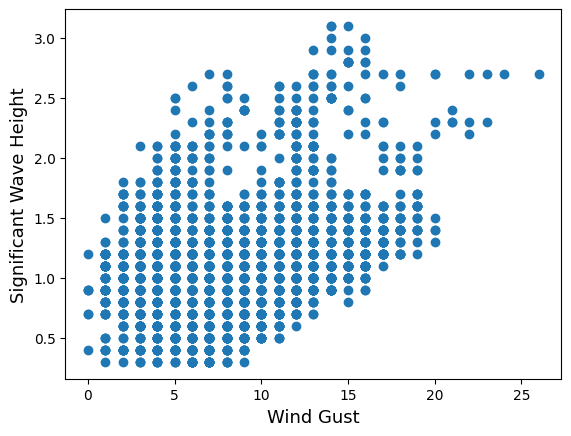

In [8]:
fig, ax = plt.subplots()
ax.scatter(x = ny_buoy['wind_gust'], y = ny_buoy['wave_height'])
plt.ylabel('Significant Wave Height', fontsize=13)
plt.xlabel('Wind Gust', fontsize=13)
plt.show()

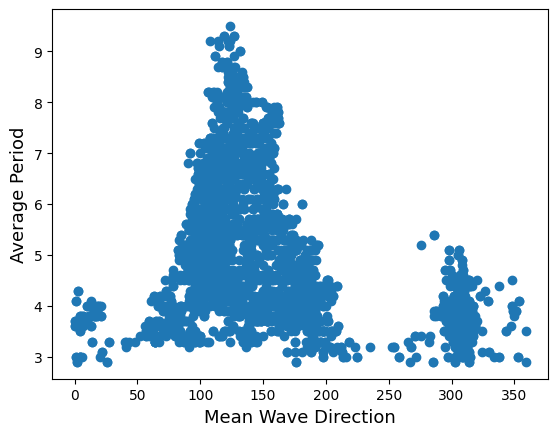

In [9]:
fig, ax = plt.subplots()
ax.scatter(x = ny_buoy['mean_wave_direction'], y = ny_buoy['average_period'],)
plt.ylabel('Average Period', fontsize=13)
plt.xlabel('Mean Wave Direction', fontsize=13)
plt.show()

In [10]:
# Remove non finite values
ny_buoy_mode = ny_buoy_mode[np.isfinite(ny_buoy_mode['wave_height'])]
ny_buoy_mean = ny_buoy_mean[np.isfinite(ny_buoy_mean['wave_height'])]
ny_buoy_interpolated = ny_buoy_interpolated[np.isfinite(ny_buoy_interpolated['wave_height'])]


 mu = 0.73 and sigma = 0.21



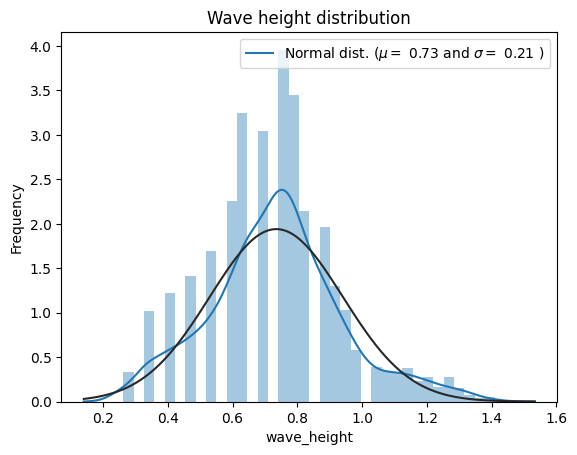

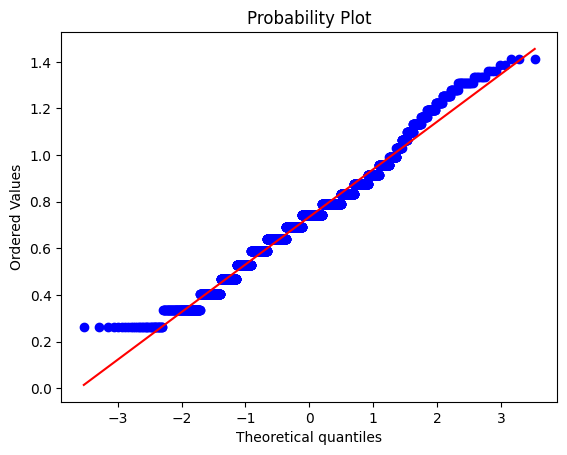

In [11]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
ny_buoy_mode["wave_height"] = np.log1p(ny_buoy_mode["wave_height"])
ny_buoy_mean["wave_height"] = np.log1p(ny_buoy_mean["wave_height"])
ny_buoy_interpolated["wave_height"] = np.log1p(ny_buoy_interpolated["wave_height"])


# Check the new distribution 
sns.distplot(ny_buoy_mode['wave_height'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(ny_buoy_mode['wave_height'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Wave height distribution')

# Get also the QQ-plot
fig = plt.figure()
res = probplot(ny_buoy_mode['wave_height'], plot=plt)
plt.show()

In [12]:
ny_buoy_mean

wind_speed  wind_gust  wave_height  dominant_period  average_period  \
0            6.0        8.0     0.470004          7.74384             3.5   
1            6.0        7.0     0.470004          3.00000             3.5   
2            5.0        7.0     0.470004          7.74384             3.5   
3            5.0        6.0     0.470004          8.00000             3.5   
4            5.0        6.0     0.470004          7.74384             3.5   
...          ...        ...          ...              ...             ...   
3337         6.0        8.0     0.741937          7.74384             5.7   
3338         7.0        8.0     0.741937          8.00000             5.7   
3339         6.0        8.0     0.741937          7.74384             5.4   
3340         7.0        8.0     0.741937          8.00000             5.4   
3341         7.0        9.0     0.788457          9.00000             5.5   

      mean_wave_direction  pressure  water_temp  pressure_tendency  
0                   204.0    1018.0         5.4            0.01875  
1                   204.0    1018.1         5.4            0.01875  
2                   161.0    1017.8         5.4            0.01875  
3                   161.0    1017.8         5.4            0.01875  
4                   198.0    1018.0         5.4            0.01875  
...                   ...       ...         ...                ...  
3337                157.0    1027.3         7.0            0.01875  
3338                157.0    1027.3         6.9            0.01875  
3339                135.0    1027.3         6.9            0.01875  
3340                135.0    1027.4         6.9            0.01875  
3341                144.0    1027.3         6.9            0.01875  

[3342 rows x 9 columns]

In [45]:
ny_buoy_mean

wind_speed  wind_gust  wave_height  dominant_period  average_period  \
0            6.0        8.0     0.470004          7.74384        1.504077   
1            6.0        7.0     0.470004          3.00000        1.504077   
2            5.0        7.0     0.470004          7.74384        1.504077   
3            5.0        6.0     0.470004          8.00000        1.504077   
4            5.0        6.0     0.470004          7.74384        1.504077   
...          ...        ...          ...              ...             ...   
3337         6.0        8.0     0.741937          7.74384        1.902108   
3338         7.0        8.0     0.741937          8.00000        1.902108   
3339         6.0        8.0     0.741937          7.74384        1.856298   
3340         7.0        8.0     0.741937          8.00000        1.856298   
3341         7.0        9.0     0.788457          9.00000        1.871802   

      mean_wave_direction  pressure  water_temp  pressure_tendency  
0                   204.0    1018.0         5.4            0.01875  
1                   204.0    1018.1         5.4            0.01875  
2                   161.0    1017.8         5.4            0.01875  
3                   161.0    1017.8         5.4            0.01875  
4                   198.0    1018.0         5.4            0.01875  
...                   ...       ...         ...                ...  
3337                157.0    1027.3         7.0            0.01875  
3338                157.0    1027.3         6.9            0.01875  
3339                135.0    1027.3         6.9            0.01875  
3340                135.0    1027.4         6.9            0.01875  
3341                144.0    1027.3         6.9            0.01875  

[3342 rows x 9 columns]


 mu = 1.77 and sigma = 0.22



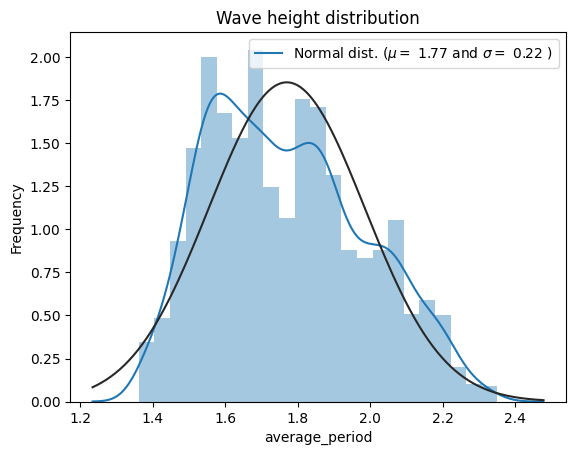

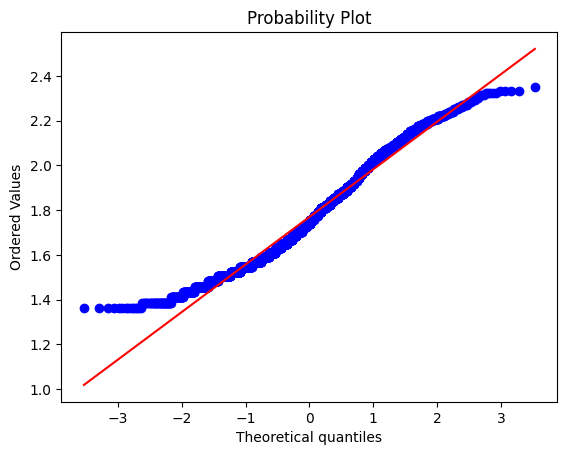

In [14]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
ny_buoy_mode["average_period"] = np.log1p(ny_buoy_mode["average_period"])
ny_buoy_mean["average_period"] = np.log1p(ny_buoy_mean["average_period"])
ny_buoy_interpolated["average_period"] = np.log1p(ny_buoy_interpolated["average_period"])

# Check the new distribution 
sns.distplot(ny_buoy_mode['average_period'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(ny_buoy_mode['average_period'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Wave height distribution')

# Get also the QQ-plot
fig = plt.figure()
res = probplot(ny_buoy_mode['average_period'], plot=plt)
plt.show()

### Data Analysis and Visualization

In [15]:
from sklearn.preprocessing import LabelEncoder

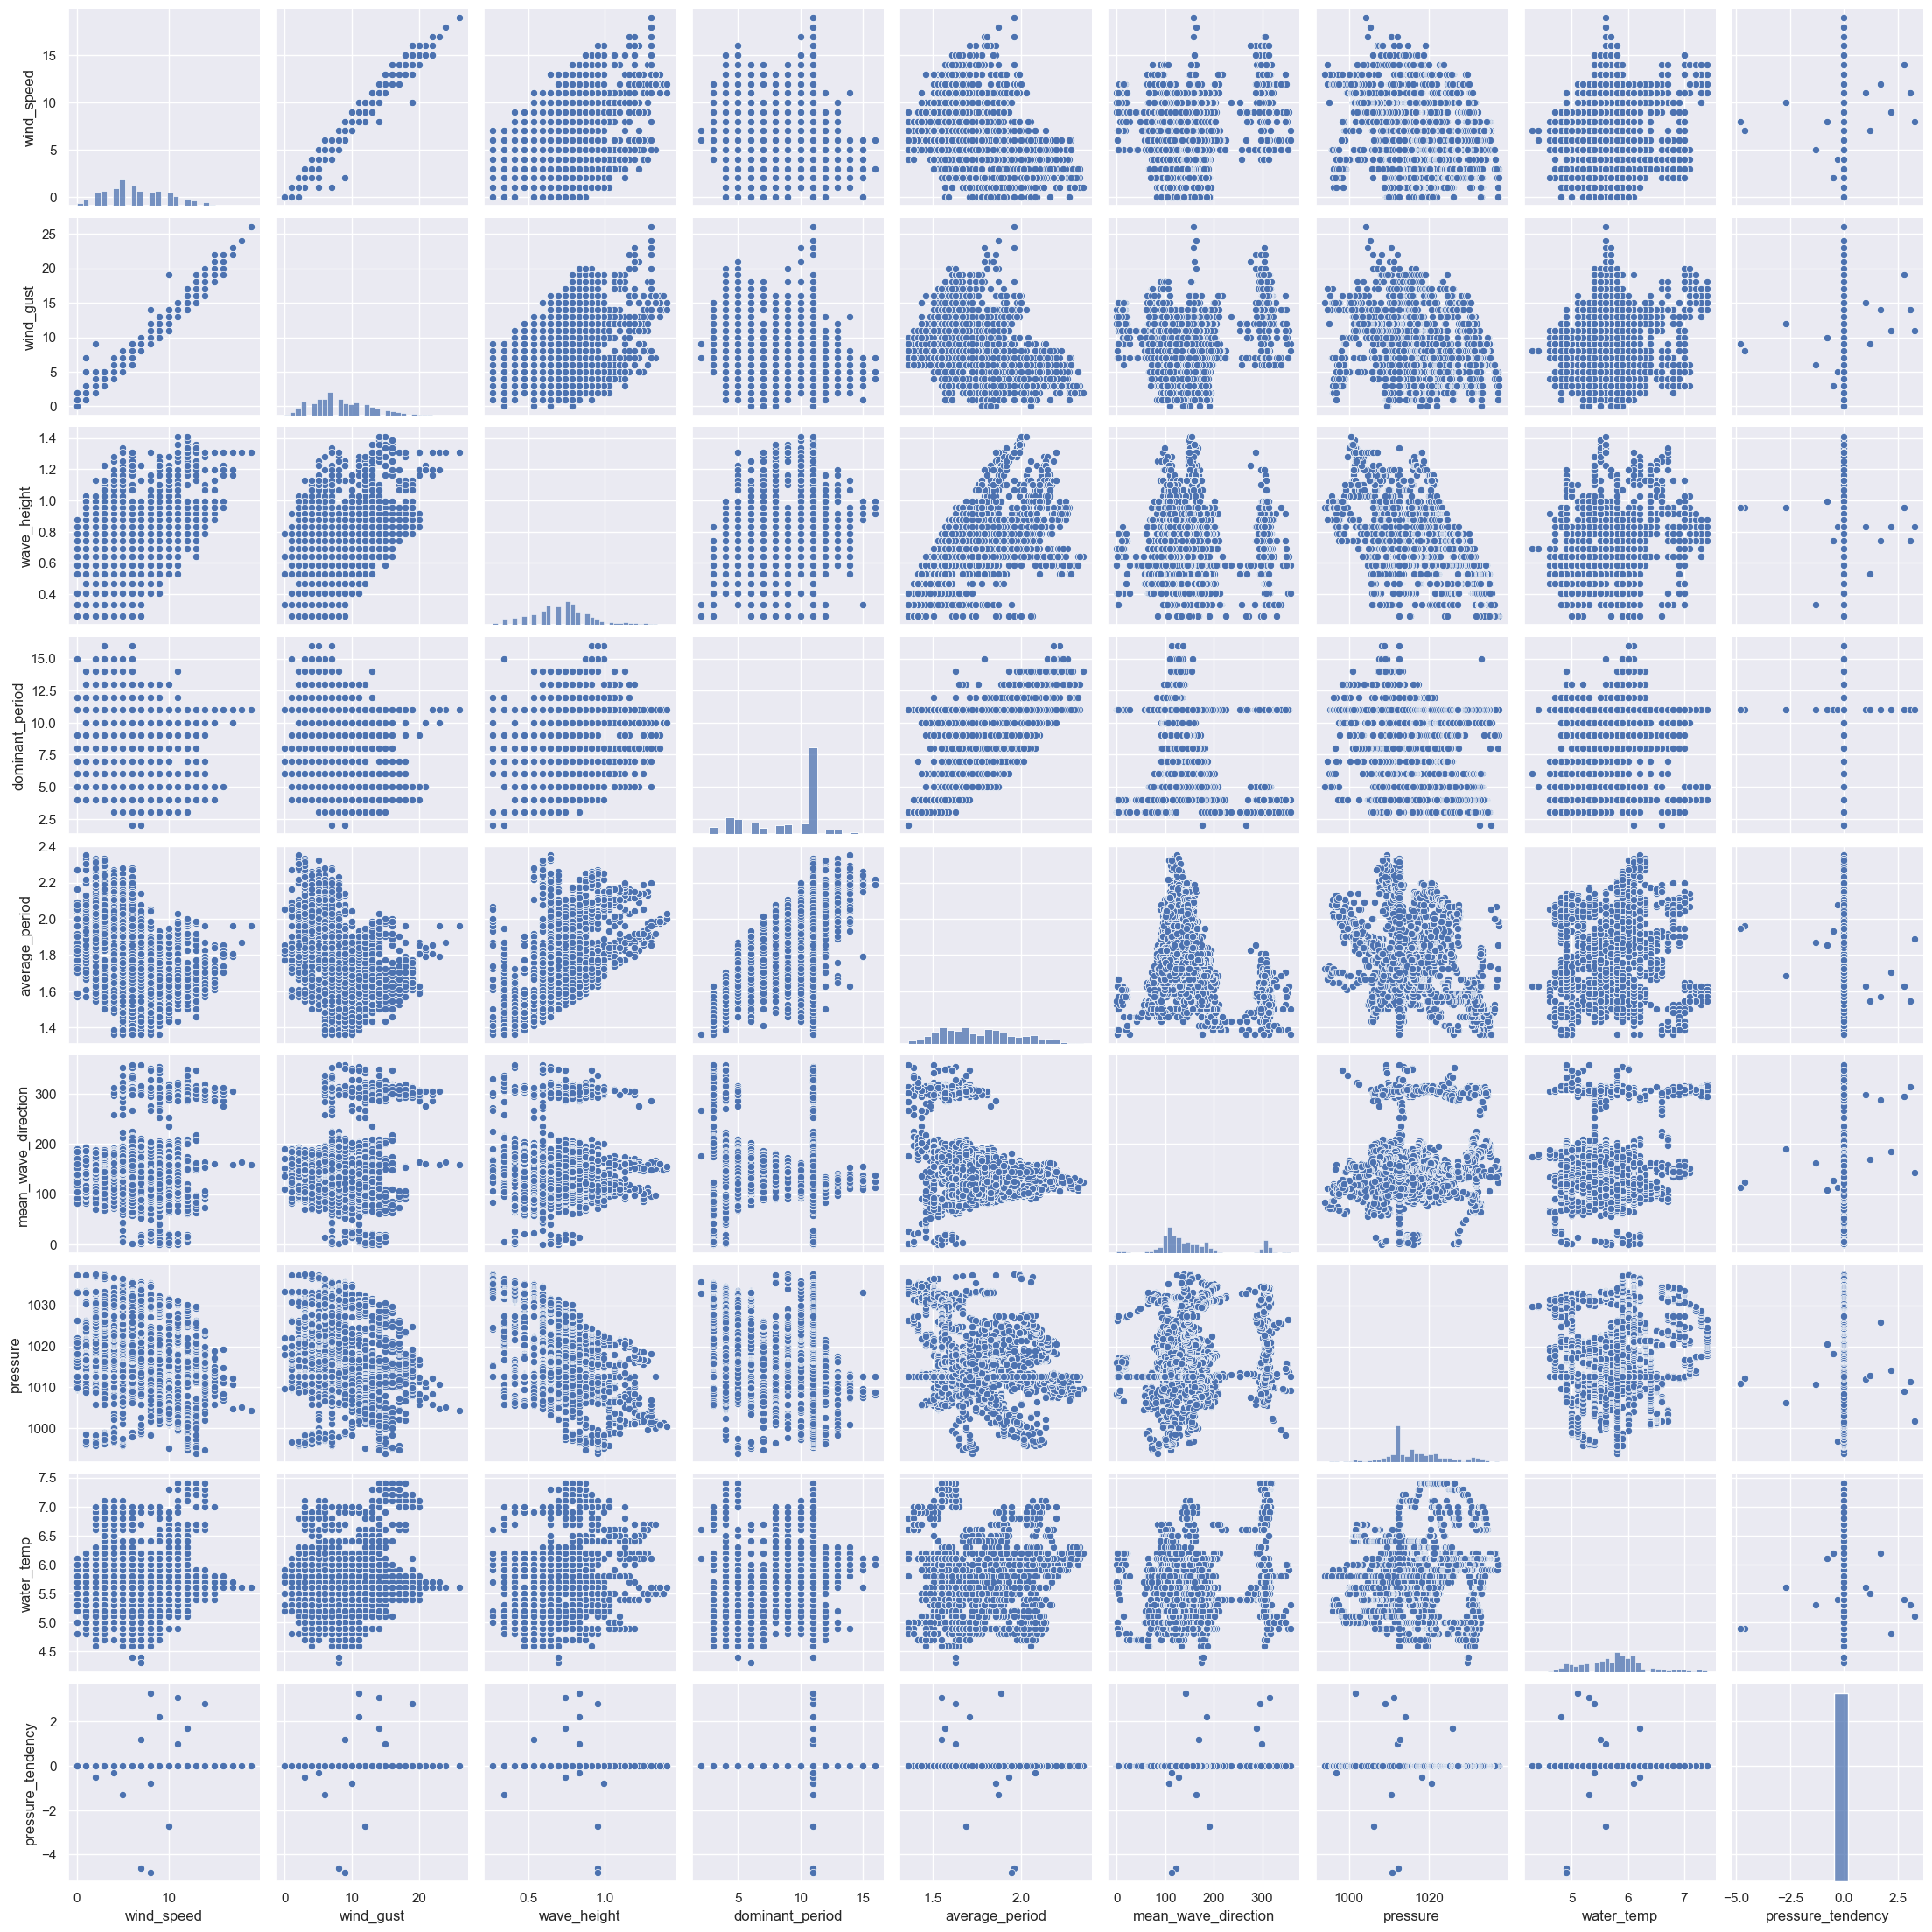

In [16]:
# scatterplot
sns.set()
cols = ['wind_speed', 'wind_gust', 'wave_height', 
        'dominant_period', 'average_period', 'mean_wave_direction', 
        'pressure', 'water_temp',
        'pressure_tendency']
sns.pairplot(ny_buoy_mode[cols], size = 2.5)
plt.show();

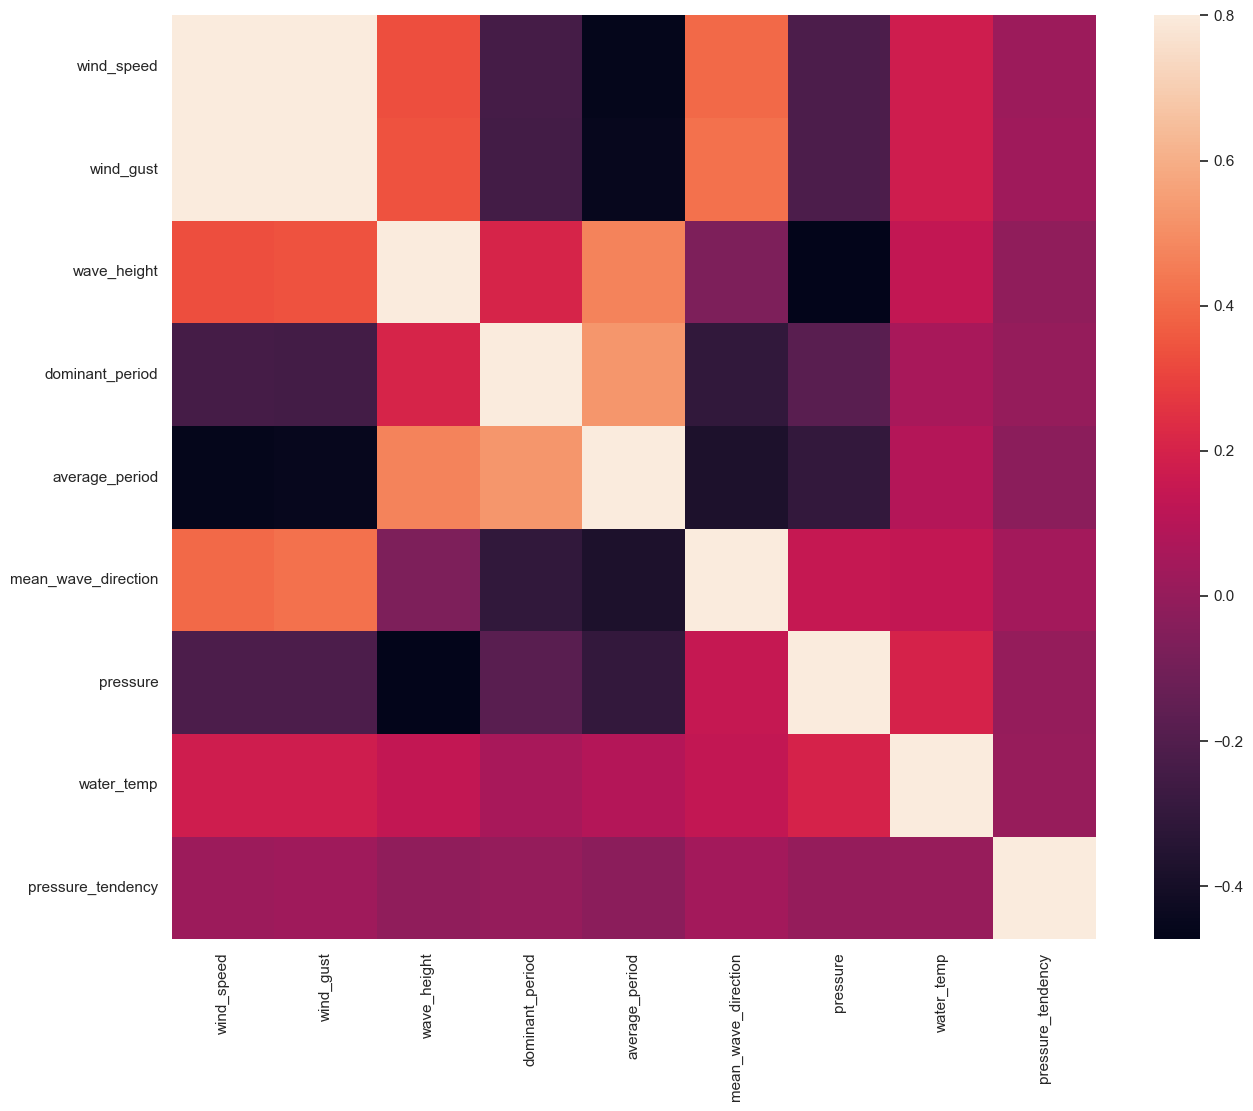

In [17]:
# Correlation map to see how conditions are correlated with wave height and average period
corrmat = ny_buoy_mode.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

# Data Analytics
## Using algorithms on different imputations
* [ny_buoy_mode](#mode)
* [ny_buoy_mean](#mean)
* [ny_buoy_interpolated](#interpolate)

### Imputed on mode <a class="anchor" id="mode"></a>

In [18]:
import sys

!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install lightgbm

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb


[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [19]:
train_df = ny_buoy[ny_buoy_mode.columns.difference(['wave_height', 'average_period'])]
train_df.head()

dominant_period  mean_wave_direction  pressure  \
date                                                                  
2024-01-19 00:10:00              NaN                204.0    1018.0   
2024-01-19 00:20:00              3.0                204.0    1018.1   
2024-01-19 00:40:00              NaN                161.0    1017.8   
2024-01-19 00:50:00              8.0                161.0    1017.8   
2024-01-19 01:10:00              NaN                198.0    1018.0   

                     pressure_tendency  water_temp  wind_gust  wind_speed  
date                                                                       
2024-01-19 00:10:00                NaN         5.4        8.0         6.0  
2024-01-19 00:20:00                NaN         5.4        7.0         6.0  
2024-01-19 00:40:00                NaN         5.4        7.0         5.0  
2024-01-19 00:50:00                NaN         5.4        6.0         5.0  
2024-01-19 01:10:00                NaN         5.4        6.0         5.0

In [20]:
# Validation function for wave height
n_folds = 5

def rmse_cv(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse = np.sqrt(-cross_val_score(model, train_df, ny_buoy_mode.wave_height, scoring="neg_mean_squared_error", cv = kf))
    return rmse

In [21]:
lr_w_int = LinearRegression()
lr_no_int = LinearRegression(fit_intercept=False)

In [22]:
neigh = KNeighborsRegressor(n_neighbors=10)

In [23]:
rf = RandomForestRegressor(n_estimators=100)

In [24]:
dt = DecisionTreeRegressor(max_depth = 10)

In [25]:
model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)

In [26]:
model_lgb = lgb.LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

In [27]:
score_dt = rmse_cv(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

Decision Tree Regression score: 0.1843 (0.0500)



In [28]:
score_rf = rmse_cv(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

Random Forest Regression score: 0.1823 (0.0496)



In [29]:
score_xg = rmse_cv(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

Xgboost score: 0.2039 (0.0348)



In [30]:
score_lgbm = rmse_cv(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 529
[LightGBM] [Info] Number of data points in the train set: 2673, number of used features: 6
[LightGBM] [Info] Start training from score 0.762219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

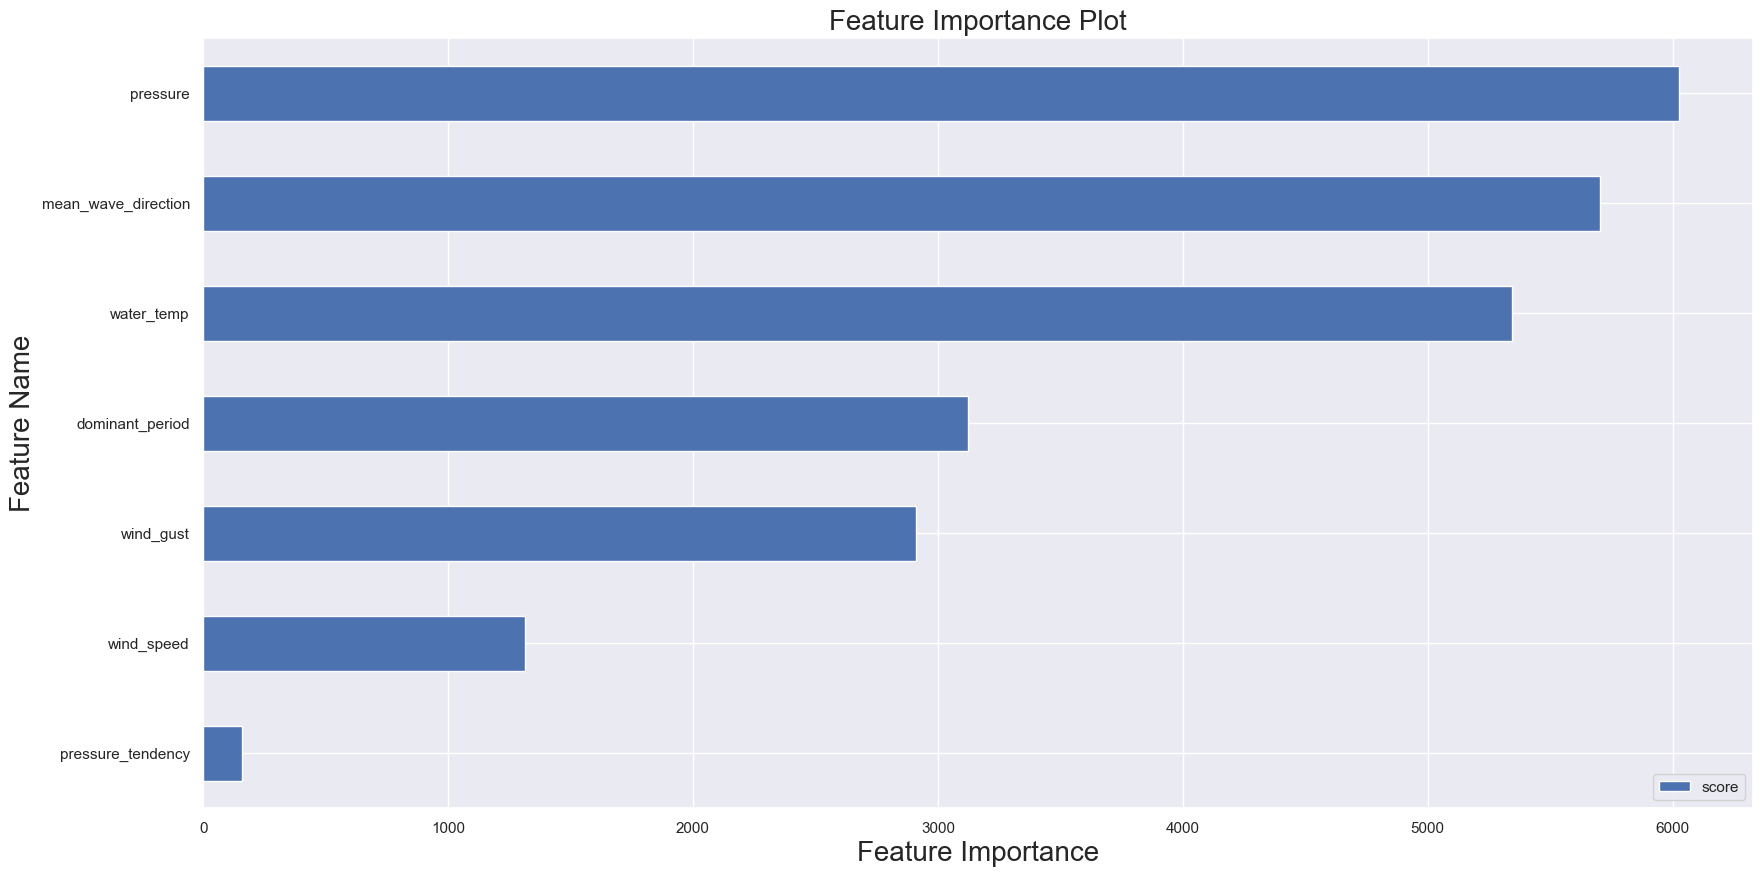

In [31]:
model = model_xgb.fit(train_df, ny_buoy_mode.wave_height) #fit model on entire dataset to get variable importance since we fit it on each fold
feature_important = model.get_booster().get_score(importance_type='weight')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data[:20].plot(kind='barh', figsize = (20,10)).invert_yaxis(); ## plot top 20 features
plt.xlabel("Feature Importance",fontsize=20)
plt.ylabel("Feature Name",fontsize=20)
plt.title("Feature Importance Plot",fontsize=20)
plt.show()

#### Repeat Training Models, but for Average Period

In [32]:
# Validation function for wave height
n_folds = 5

def rmse_cv_period(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse_period = np.sqrt(-cross_val_score(model, train_df, ny_buoy_mode.average_period, scoring="neg_mean_squared_error", cv = kf))
    return rmse_period

In [33]:
score_dt = rmse_cv_period(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

Decision Tree Regression score: 0.1969 (0.0378)



In [34]:
score_rf = rmse_cv_period(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

Random Forest Regression score: 0.1752 (0.0406)



In [35]:
score_xg = rmse_cv_period(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

Xgboost score: 0.1507 (0.0248)



In [36]:
score_lgbm = rmse_cv_period(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 529
[LightGBM] [Info] Number of data points in the train set: 2673, number of used features: 6
[LightGBM] [Info] Start training from score 1.806839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 3342, number of used features: 6
[LightGBM] [Info] Start training from score 1.769933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

<Axes: title={'center': 'LightGBM Feature Importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

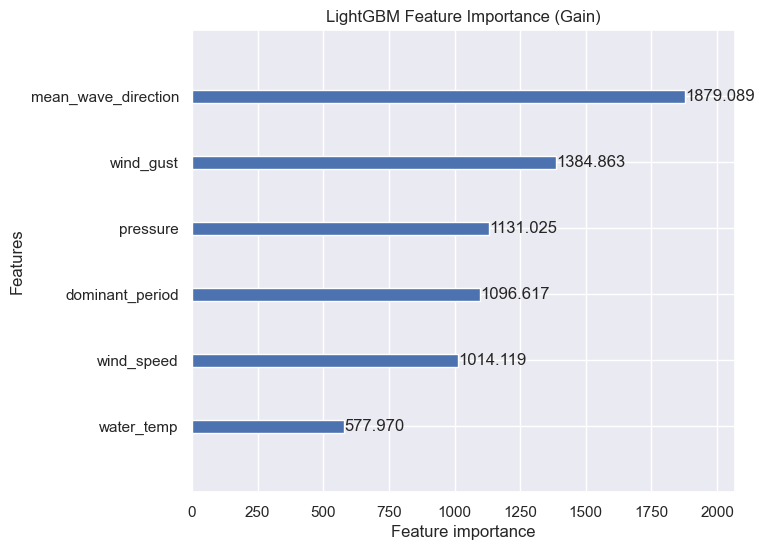

In [37]:
model = model_lgb.fit(train_df, ny_buoy_mode.average_period) #fit model on entire dataset to get variable importance since we fit it on each fold
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")

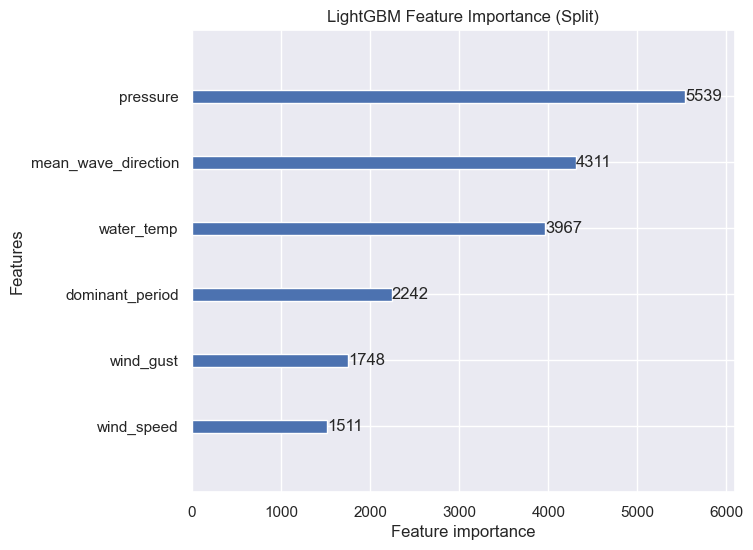

In [38]:
# Plot feature importance using Split
lgb.plot_importance(model, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

### Imputed on mean <a class="anchor" id="mean"></a>

In [39]:
train_df = ny_buoy_mean[ny_buoy_mean.columns.difference(['wave_height', 'average_period'])]
train_df.head()

# Validation function for wave height
n_folds = 5

def rmse_cv(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse = np.sqrt(-cross_val_score(model, train_df, ny_buoy_mean.wave_height, scoring="neg_mean_squared_error", cv = kf))
    return rmse

lr_w_int = LinearRegression()
lr_no_int = LinearRegression(fit_intercept=False)
neigh = KNeighborsRegressor(n_neighbors=10)
rf = RandomForestRegressor(n_estimators=100)
dt = DecisionTreeRegressor(max_depth = 10)
model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)
model_lgb = lgb.LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

score_dt = rmse_cv(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

score_rf = rmse_cv(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

score_xg = rmse_cv(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

score_lgbm = rmse_cv(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

Decision Tree Regression score: 0.2156 (0.0536)

Random Forest Regression score: 0.2046 (0.0482)

Xgboost score: 0.2010 (0.0392)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 529
[LightGBM] [Info] Number of data points in the train set: 2673, number of used features: 6
[LightGBM] [Info] Start training from score 0.762219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

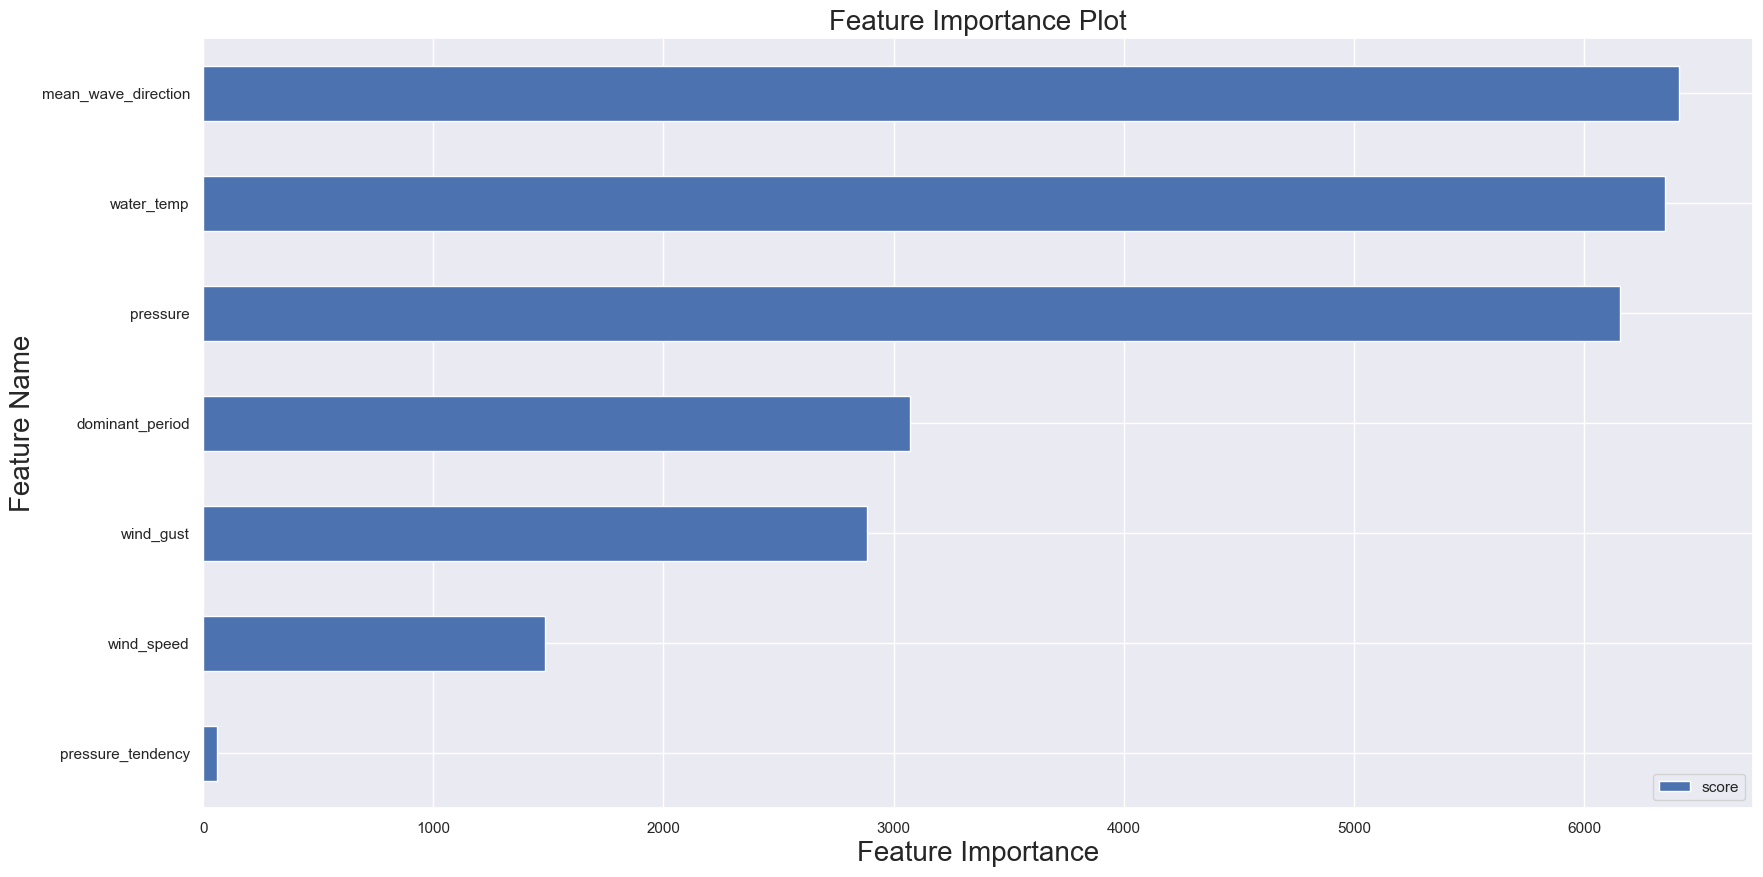

In [40]:
model = model_xgb.fit(train_df, ny_buoy_mean.wave_height) #fit model on entire dataset to get variable importance since we fit it on each fold
feature_important = model.get_booster().get_score(importance_type='weight')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data[:20].plot(kind='barh', figsize = (20,10)).invert_yaxis(); ## plot top 20 features
plt.xlabel("Feature Importance",fontsize=20)
plt.ylabel("Feature Name",fontsize=20)
plt.title("Feature Importance Plot",fontsize=20)
plt.show()

#### Repeat Training Models, but for Average Period

In [41]:
def rmse_cv(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse = np.sqrt(-cross_val_score(model, train_df, ny_buoy_mean.average_period, scoring="neg_mean_squared_error", cv = kf))
    return rmse

lr_w_int = LinearRegression()
lr_no_int = LinearRegression(fit_intercept=False)
neigh = KNeighborsRegressor(n_neighbors=10)
rf = RandomForestRegressor(n_estimators=100)
dt = DecisionTreeRegressor(max_depth = 10)
model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)
model_lgb = lgb.LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

score_dt = rmse_cv(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

score_rf = rmse_cv(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

score_xg = rmse_cv(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

score_lgbm = rmse_cv(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

Decision Tree Regression score: 0.1698 (0.0230)

Random Forest Regression score: 0.1493 (0.0273)

Xgboost score: 0.1467 (0.0228)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 529
[LightGBM] [Info] Number of data points in the train set: 2673, number of used features: 6
[LightGBM] [Info] Start training from score 1.806839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

### Imputed on interpolation <a class="anchor" id="interpolate"></a>

In [42]:
train_df = ny_buoy_interpolated[ny_buoy_interpolated.columns.difference(['wave_height', 'average_period'])]
train_df.head()

# Validation function for wave height
n_folds = 5

def rmse_cv(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse = np.sqrt(-cross_val_score(model, train_df, ny_buoy_interpolated.wave_height, scoring="neg_mean_squared_error", cv = kf))
    return rmse

lr_w_int = LinearRegression()
lr_no_int = LinearRegression(fit_intercept=False)
neigh = KNeighborsRegressor(n_neighbors=10)
rf = RandomForestRegressor(n_estimators=100)
dt = DecisionTreeRegressor(max_depth = 10)
model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)
model_lgb = lgb.LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

score_dt = rmse_cv(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

score_rf = rmse_cv(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

score_xg = rmse_cv(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

score_lgbm = rmse_cv(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

Decision Tree Regression score: 0.1991 (0.0726)

Random Forest Regression score: 0.1775 (0.0458)

Xgboost score: 0.1932 (0.0645)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1092
[LightGBM] [Info] Number of data points in the train set: 2673, number of used features: 7
[LightGBM] [Info] Start training from score 0.762219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

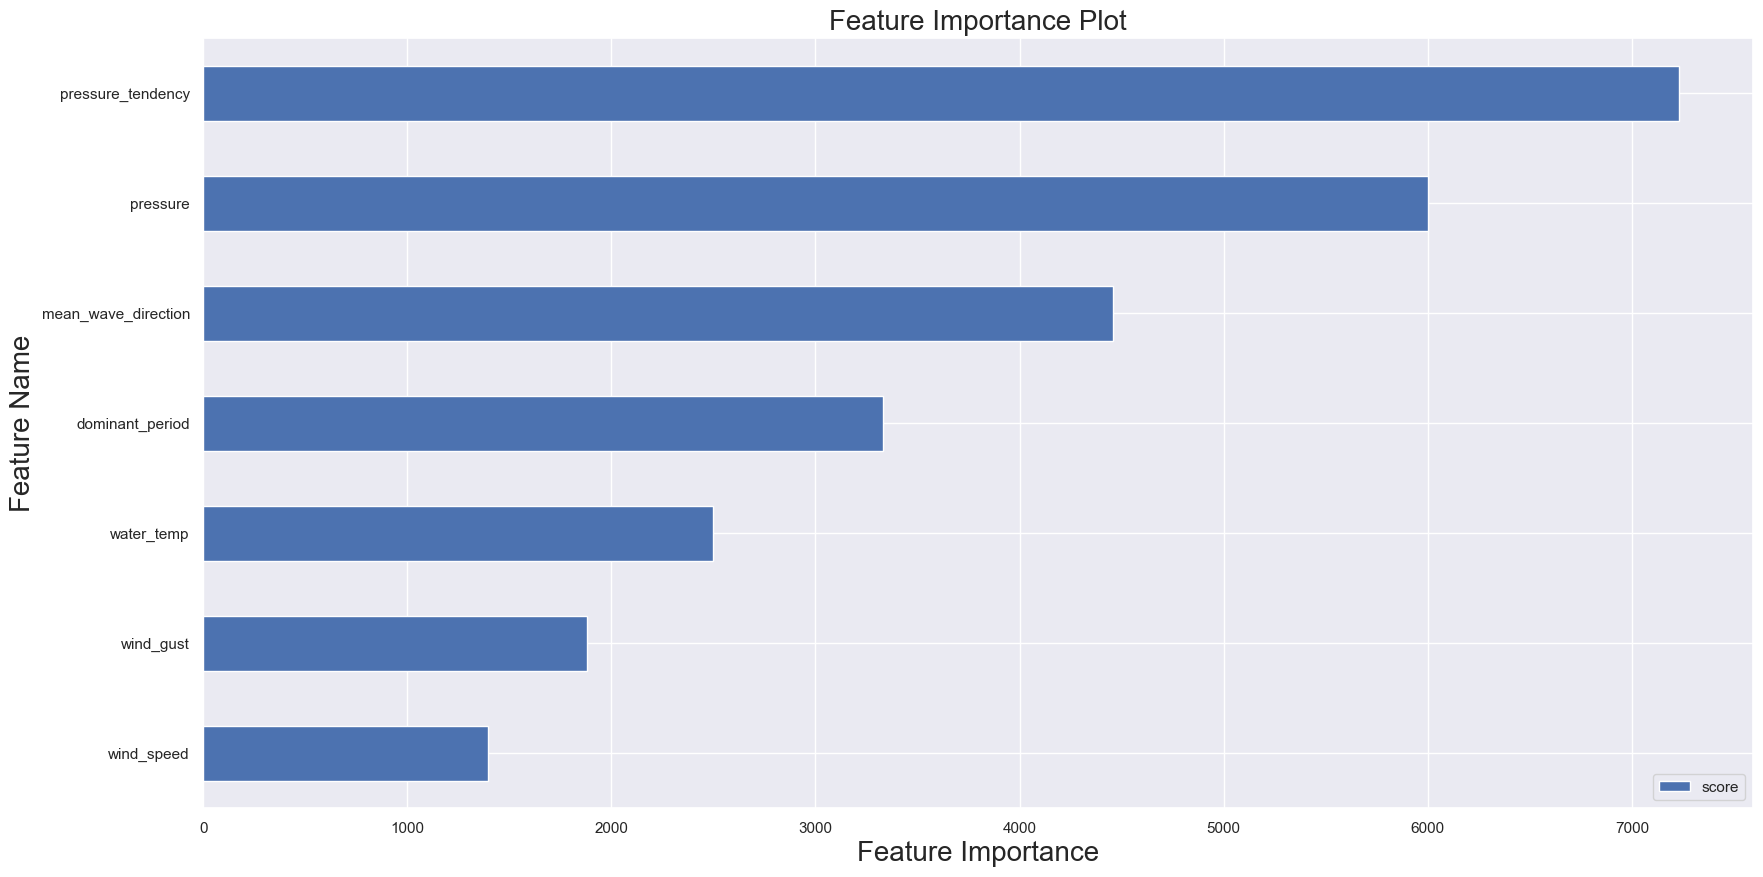

In [43]:
model = model_xgb.fit(train_df, ny_buoy_interpolated.wave_height) #fit model on entire dataset to get variable importance since we fit it on each fold
feature_important = model.get_booster().get_score(importance_type='weight')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data[:20].plot(kind='barh', figsize = (20,10)).invert_yaxis(); ## plot top 20 features
plt.xlabel("Feature Importance",fontsize=20)
plt.ylabel("Feature Name",fontsize=20)
plt.title("Feature Importance Plot",fontsize=20)
plt.show()

#### Repeat Training Models, but for Average Period (interpolate)

In [44]:
def rmse_cv(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse = np.sqrt(-cross_val_score(model, train_df, ny_buoy_interpolated.average_period, scoring="neg_mean_squared_error", cv = kf))
    return rmse

lr_w_int = LinearRegression()
lr_no_int = LinearRegression(fit_intercept=False)
neigh = KNeighborsRegressor(n_neighbors=10)
rf = RandomForestRegressor(n_estimators=100)
dt = DecisionTreeRegressor(max_depth = 10)
model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)
model_lgb = lgb.LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

score_dt = rmse_cv(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

score_rf = rmse_cv(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

score_xg = rmse_cv(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

score_lgbm = rmse_cv(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

Decision Tree Regression score: 0.1693 (0.0247)

Random Forest Regression score: 0.1386 (0.0302)

Xgboost score: 0.1422 (0.0362)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1092
[LightGBM] [Info] Number of data points in the train set: 2673, number of used features: 7
[LightGBM] [Info] Start training from score 1.806839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p